In [286]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from tqdm import tqdm
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler as SS
matplotlib.rcParams['figure.figsize'] = [10.0, 10.0]
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.color'] = 'r'
matplotlib.rcParams['font.size'] = 20.0
matplotlib.rcParams['figure.dpi'] = 100

In [327]:
import keras
from keras.layers import Dense, Dropout, Input,Lambda, concatenate, add, AlphaDropout,GaussianDropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.activations import selu, relu
from keras.losses import mae, mse
from keras.optimizers import Nadam
from keras.models import Model
from keras.constraints import maxnorm
from IPython.display import clear_output

In [288]:
X_df = pd.read_csv('./data/final_10.csv',index_col=0)
Y_df = pd.read_csv('./data/final_whole.csv',index_col=0)

In [289]:
X_df = X_df.sort_index()
Y_df = Y_df.sort_index()

In [290]:
X = X_df.values
Y = Y_df.values

In [291]:
X.shape

(6348, 66)

In [292]:
Y.shape

(6348, 66)

In [293]:
X_train, X_test, y_train, y_test = tts(X, Y, test_size=0.2, random_state=42)
X_train, X_v, y_train, y_v = tts(X_train, y_train, test_size=0.3, random_state=42)

#extracting id's of depressed and normal entries to use it later in the test set analysis.

test_entries_in_X = {}
for i in tqdm(range(y_test.shape[0])):
    for j in range(X.shape[0]):
        if (X_test[i,:]==X[j,:]).all():
            test_entries_in_X[i]=j

scaler = SS()
X_train = scaler.fit_transform(X_train)
X_v = scaler.transform(X_v)
X_test = scaler.transform(X_test)

scaler = SS()
y_train = scaler.fit_transform(y_train)
y_v = scaler.transform(y_v)
y_test = scaler.transform(y_test)

100%|██████████████████████████████████████████████████████████████████████████████| 1270/1270 [00:28<00:00, 44.68it/s]


## Doing a couple of data visualizations (not particulaly useful - kind of an additional sanity check)

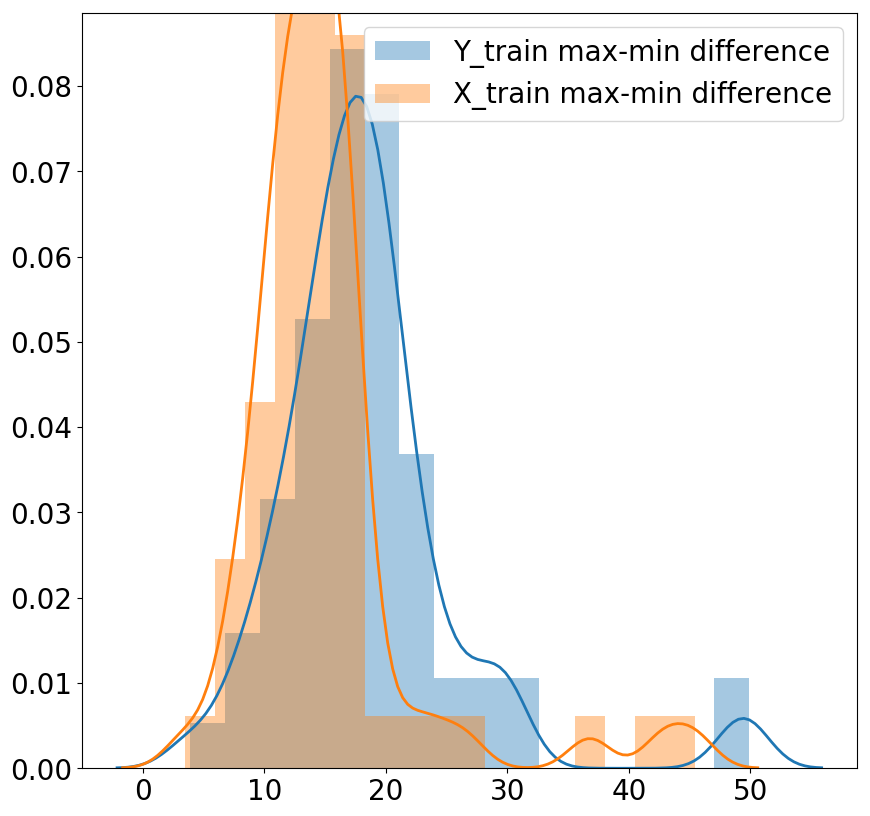

In [294]:
sns.distplot(np.max(y_train,axis=0)-np.min(y_train,axis=0),label='Y_train max-min difference')
sns.distplot(np.max(X_train,axis=0)-np.min(X_train,axis=0),label='X_train max-min difference')
plt.legend()

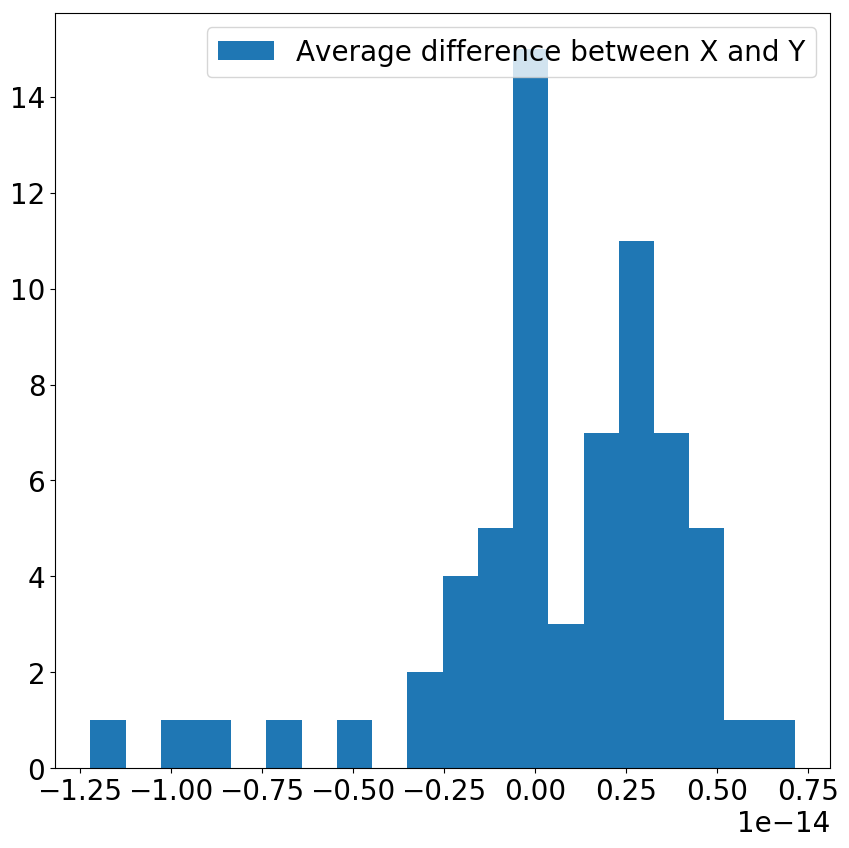

In [295]:
#sns.distplot(np.average(X_train-y_train,axis=0),label='Average between X and Y')
plt.hist(np.average(X_train-y_train,axis=0),label='Average difference between X and Y',bins=20)
plt.legend()
plt.show()

### Building a simple DL model, allowing to predict all the features at the same time

In [355]:
def init_model(inp_shape):
    dout = 0.30
    a = Input(shape=(inp_shape,))
    b = GaussianDropout(dout/2.0)(a)
    #b = BatchNormalization()(a)
    b = Dense(64,activation='selu')(b)
    b = GaussianDropout(dout)(b)
    #b = BatchNormalization()(b)
    #b = Dense(128,activation='relu')(b)
    #b = BatchNormalization()(b)
    #b = Dropout(dout)(b)
    #b = Dense(256,activation='selu')(b)
    #b = Dropout(dout)(b)
    #b = Dense(128,activation='selu')(b)

    output = Dense(inp_shape,activation='linear')(b)

    model = Model(inputs=a, outputs=output)
    opt = Nadam(1e-4)
    model.compile(optimizer = opt, loss=mse,)
    
    return model

# the class is retrieved from: https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [356]:
model = init_model(inp_shape=X_train.shape[1])

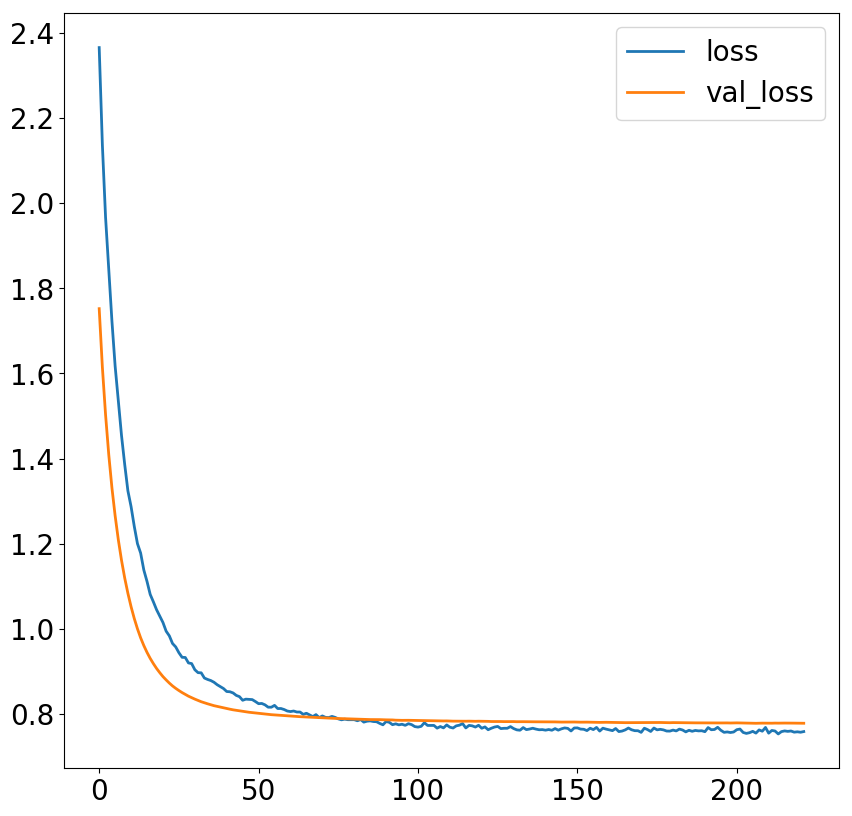

In [357]:
history = model.fit(X_train, y_train, epochs=1000, batch_size=32,validation_data=(X_v,y_v),callbacks=[EarlyStopping(patience=15),plot_losses],shuffle=True,verbose=0)

# Trying to answer a research question, whether depressed people are less stationary

In [358]:
# getting all depressed people IDs
df1 = pd.read_csv('./data/negative_ten.csv',index_col=0)

In [359]:
depressed = df1.index.tolist()
all_ppl = X_df.index.tolist()

In [360]:
depressed_positions = []
for pers in depressed:
    depressed_positions.append(all_ppl.index(pers))
depressed_positions.sort()

In [361]:
y_pred = model.predict(X_test)

In [362]:
for i in list(test_entries_in_X.keys()):
    if test_entries_in_X[i] in depressed_positions:
        test_entries_in_X[i] = 1
    else:
        test_entries_in_X[i] = 0

## There is a set of features, for which an average difference abs(y_pred-y_test) is above 50% between for and normal people. Allows to tell, which features are well-predicted for depressed and worse for normal and vice versa

In [364]:
positive = [np.array(list(test_entries_in_X.values()))==1]
negative = [np.array(list(test_entries_in_X.values()))==0]
differing_features = []
for k in range(X_test.shape[1]):
    #_______________________________________absolute error between prediction and real value
    data=abs(y_test[:,k]-y_pred[:,k])
    data_p = data[positive] 
    data_n = data[negative]

    
    if abs(np.average(data_p)-np.average(data_n))>0.5*(np.average(data_n)+np.average(data_p))/2.0:    
        differing_features.append(k)
        #print('Different averages:')
        print(X_df.columns.tolist()[k])
        print('averages: ', np.average(data_p),np.average(data_n))       

vad_1
averages:  0.39796467434 0.677428158283
time_2
averages:  0.425896428512 0.724596583499
time_17
averages:  0.463379302395 0.773400763877
depression_symptoms_count_0
averages:  0.25925910063 0.15191216185
depression_symptoms_count_1
averages:  0.377779157528 0.209755894248
depression_symptoms_count_2
averages:  0.410493402393 0.206611505169
depression_symptoms_count_4
averages:  0.301319734534 0.151448929002
depression_symptoms_count_5
averages:  0.364312248308 0.166592749381
depression_symptoms_count_6
averages:  0.347067537785 0.193411671714
depression_symptoms_count_7
averages:  0.361423229813 0.212355532597
lda_6
averages:  0.247359563094 0.562502363791


### Is (negative_)positive_words_count,positive_emoji_count normalized? How?

### What are days and vad features?
### How is text_length normalized?

# It is 2 times harder to predict retweet_count, positive_words_count, etc. for depressed people in comparison to normal. Which makes depressed people less stationary (less sable!). 
# text_length_div_by_posts_number_all is 3 times easier to predict for depressed patients, reply_ratio_div_by_retweet_count_plus_one is 70% easier to predict for depressed people
## If features are harder to predict -> they are less deterministic -> the person is more stochastic
